### 分组测试经典方法
2022-07-17
- univ矩阵要求：所有值都没有缺失
2022-08-07
- 改成5元划分的两组
2022-08-16
- 通过bootstrap计算估计标准差
2022-09-03
- bootstrap计算分位点

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/18316/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Windows11/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
from mytools.AutoTester import AutoTester

from time import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
se = SpreadEstimator()

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'D:/Documents/学习资料/DailyData/data'

### 构造两组univ

In [4]:
univ = se.data.data_dic['volume'] > 0  # 当天有交易
th = 0.8

# univ_2 = []
# for i in range(2081):
#     if np.sum(se.data.data_dic['close'][univ[:,i],i]>10) >= th * 243:
#         univ_2.append(1)
#     else:
#         univ_2.append(0)
# univ_2 = np.array(univ_2) > 0
# print(np.sum(univ_2))
# univ_2 = np.repeat(univ_2.reshape(1,2081), 243, 0)

univ_1 = []
for i in range(2081):
    if np.sum(se.data.data_dic['close'][univ[:,i],i]>5) >= th * 243:
        univ_1.append(1)
    else:
        univ_1.append(0)
univ_1 = np.array(univ_1) > 0
univ_1 = np.repeat(univ_1.reshape(1,2081), 243, 0)
print(np.sum(univ_1[0]))

univ_0 = (~univ_1)
print(np.sum(univ_0[0]))

univ_0 = univ_0 & univ
univ_1 = univ_1 & univ

all_univ = [univ_0, univ_1]

1549
532


In [16]:
import pickle
with open(r"D:\Documents\学习资料\本科毕业论文\data\close_top.pkl", 'wb') as f:
    pickle.dump(univ_1, f)

### 在2组股票中测试

In [7]:
def test_cs(signal, target, univ, back: int = 1):
    corr = []
    for i in range(signal.shape[0]):
        if i < back-1:
            continue
        t = np.nanmean(target[i-back+1: i+1], axis=0)
        se = (~np.isnan(t)) & (~np.isnan(signal[i])) & univ[i]
        if np.sum(se) < 2:
            continue
        corr.append(np.corrcoef(signal[i, se], t[se])[0, 1])
    print('{:.4f}'.format(np.nanmean(corr)))
    return corr

def test_ts(signal, target, univ, back: int = 1):
    corr = []
    new_t = np.zeros((len(target)-back+1, target.shape[1]))
    for i in range(new_t.shape[0]):
        new_t[i] = np.nanmean(target[i:i+back])
    for i in range(signal.shape[1]):
        t = new_t[:, i]
        se = (~np.isnan(t)) & (~np.isnan(signal[back-1:, i])) & univ[back-1:, i]
        if np.sum(se) < 2:
            continue
        corr.append(np.corrcoef(signal[back-1:, i][se], t[se])[0, 1])
    print('{:.4f}'.format(np.mean(corr)))
    return corr

def cal_std(corr, num: int=10000):  # bootstrap计算标准差和分位点
    corr = np.array(corr)
    corr_ = []
    lst = [i for i in range(len(corr))]
    for n in range(10000):
        corr_.append(np.nanmean(corr[np.random.choice(lst, len(lst))]))
    corr_ = np.sort(corr_)
    print('{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(corr_[100], corr_[500],corr_[1000],corr_[9000],corr_[9500],corr_[9900]))
    return np.std(corr_)

In [8]:
def test_rela(signal, all_univ):
    print('rela cs')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['relative_spread'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()
    print()

    print('rela ts')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['relative_spread'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()
    print()

    print('vol_wtd_rel_bas cs ')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['vol_wtd_rel_bas'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()
    print()

    print('vol_wtd_rel_bas ts ')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['vol_wtd_rel_bas'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()
        
def test_spread(signal, all_univ):
    print('spread cs')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['spread'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()
    print()

    print('spread ts')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['spread'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()

In [6]:
np.random.seed(0)

#### HL

In [9]:
beta = 'prod{tsmean{powv{minus{logv{high},logv{low}},2},2},2}'

high_1 = 'logv{tsdelay{high,1}}'
low_1 = 'logv{tsdelay{low,1}}'
con_1 = 'condition{gt{logv{low},logv{tsdelay{close,1}}},minus{logv{low},logv{tsdelay{close,1}}},minus{close,close}}'
con_2 = 'condition{lt{logv{high},logv{tsdelay{close,1}}},minus{logv{high},logv{tsdelay{close,1}}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{logv{high},' + con + '}'
low_2 = 'minus{logv{low},' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()

test_rela(signal, all_univ)

mean corr: -0.2082, positive_corr_ratio: 0.0000, corr_IR: -3.6871

rela cs
-0.1406
-0.1567, -0.1520, -0.1495, -0.1317, -0.1291, -0.1242
0.0070

-0.1765
-0.1922, -0.1875, -0.1852, -0.1677, -0.1650, -0.1605
0.0068


rela ts
0.0038
-0.0409, -0.0274, -0.0202, 0.0282, 0.0349, 0.0476
0.0189

0.0381
0.0119, 0.0199, 0.0240, 0.0529, 0.0568, 0.0642
0.0113


vol_wtd_rel_bas cs 
-0.1259
-0.1418, -0.1374, -0.1347, -0.1174, -0.1147, -0.1102
0.0068

-0.1415
-0.1574, -0.1525, -0.1501, -0.1325, -0.1300, -0.1250
0.0069


vol_wtd_rel_bas ts 
0.0082
-0.0336, -0.0219, -0.0152, 0.0322, 0.0389, 0.0518
0.0186

0.0512
0.0246, 0.0329, 0.0367, 0.0654, 0.0695, 0.0770
0.0112



In [10]:
beta = 'prod{tsmean{powv{minus{high,low},2},2},2}'
high_1 = 'tsdelay{high,1}'
low_1 = 'tsdelay{low,1}'
con_1 = 'condition{gt{low,tsdelay{close,1}},minus{low,tsdelay{close,1}},minus{close,close}}'
con_2 = 'condition{lt{high,tsdelay{close,1}},minus{high,tsdelay{close,1}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{high,' + con + '}'
low_2 = 'minus{low,' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')

print()
test_spread(signal, all_univ)

mean corr: -0.4630, positive_corr_ratio: 0.0000, corr_IR: -16.7947

spread cs
0.3754
0.3587, 0.3636, 0.3662, 0.3849, 0.3874, 0.3919
0.0072

0.7009
0.6947, 0.6966, 0.6975, 0.7042, 0.7053, 0.7071
0.0026


spread ts
0.2615
0.2347, 0.2429, 0.2470, 0.2760, 0.2801, 0.2873
0.0113

0.2625
0.2475, 0.2521, 0.2543, 0.2705, 0.2729, 0.2773
0.0064



#### Roll

In [11]:
a = 'tsdelta{logv{close},1}'
b = 'tsdelay{tsdelta{logv{close},1},1}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread')

print()
test_rela(signal, all_univ)

mean corr: 0.0994, positive_corr_ratio: 0.9279, corr_IR: 1.2409

rela cs
-0.0569
-0.0743, -0.0692, -0.0668, -0.0470, -0.0440, -0.0386
0.0077

-0.0970
-0.1082, -0.1049, -0.1032, -0.0906, -0.0888, -0.0853
0.0049


rela ts
0.0944
0.0568, 0.0677, 0.0733, 0.1153, 0.1211, 0.1320
0.0162

0.1095
0.0897, 0.0959, 0.0990, 0.1206, 0.1236, 0.1294
0.0085


vol_wtd_rel_bas cs 
-0.0368
-0.0543, -0.0491, -0.0464, -0.0272, -0.0243, -0.0184
0.0076

-0.0439
-0.0548, -0.0517, -0.0500, -0.0377, -0.0359, -0.0328
0.0048


vol_wtd_rel_bas ts 
0.1317
0.0934, 0.1054, 0.1113, 0.1528, 0.1583, 0.1690
0.0163

0.1551
0.1350, 0.1409, 0.1439, 0.1659, 0.1690, 0.1743
0.0085



In [12]:
a = 'tsdelta{close,1}'
b = 'tsdelay{tsdelta{close,1},1}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread')
print()
test_spread(signal, all_univ)

mean corr: 0.7924, positive_corr_ratio: 1.0000, corr_IR: 18.7505

spread cs
0.3684
0.3466, 0.3529, 0.3565, 0.3809, 0.3842, 0.3904
0.0095

0.7887
0.7826, 0.7844, 0.7853, 0.7920, 0.7929, 0.7946
0.0026


spread ts
0.1417
0.1175, 0.1245, 0.1282, 0.1549, 0.1586, 0.1652
0.0103

0.1621
0.1484, 0.1525, 0.1546, 0.1697, 0.1717, 0.1758
0.0059



#### CHL

In [13]:
a = 'minus{logv{tsdelay{close,1}},div{add{logv{tsdelay{high,1}},logv{tsdelay{low,1}}},2}}'
b = 'minus{logv{tsdelay{close,1}},div{add{logv{high},logv{low}},2}}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')

print()
test_rela(signal, all_univ)

mean corr: -0.2317, positive_corr_ratio: 0.0000, corr_IR: -3.9265

rela cs
-0.1404
-0.1572, -0.1522, -0.1497, -0.1309, -0.1283, -0.1232
0.0073

-0.1769
-0.1916, -0.1875, -0.1851, -0.1684, -0.1658, -0.1609
0.0066


rela ts
0.0726
0.0342, 0.0468, 0.0525, 0.0936, 0.0990, 0.1097
0.0161

0.0849
0.0640, 0.0700, 0.0732, 0.0964, 0.0994, 0.1059
0.0090


vol_wtd_rel_bas cs 
-0.1223
-0.1390, -0.1341, -0.1314, -0.1128, -0.1101, -0.1049
0.0073

-0.1301
-0.1447, -0.1406, -0.1384, -0.1218, -0.1195, -0.1152
0.0064


vol_wtd_rel_bas ts 
0.0948
0.0571, 0.0680, 0.0742, 0.1154, 0.1212, 0.1314
0.0161

0.1191
0.0977, 0.1041, 0.1075, 0.1310, 0.1346, 0.1415
0.0092



In [14]:
a = 'minus{tsdelay{close,1},div{add{tsdelay{high,1},tsdelay{low,1}},2}}'
b = 'minus{tsdelay{close,1},div{add{high,low},2}}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')

print()
test_spread(signal, all_univ)

mean corr: -0.3688, positive_corr_ratio: 0.0000, corr_IR: -8.7364

spread cs
0.3460
0.3285, 0.3334, 0.3363, 0.3558, 0.3586, 0.3634
0.0076

0.8000
0.7940, 0.7958, 0.7967, 0.8033, 0.8041, 0.8059
0.0026


spread ts
0.2436
0.2190, 0.2260, 0.2300, 0.2568, 0.2603, 0.2682
0.0105

0.2473
0.2331, 0.2373, 0.2395, 0.2554, 0.2575, 0.2617
0.0062



### bas

In [15]:
fml = 'last_rel_bas'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()
test_rela(signal, all_univ)

mean corr: 0.7343, positive_corr_ratio: 1.0000, corr_IR: 7.4584

rela cs
0.8742
0.8616, 0.8655, 0.8676, 0.8808, 0.8827, 0.8861
0.0052

0.4895
0.4781, 0.4816, 0.4833, 0.4957, 0.4973, 0.5007
0.0048


rela ts
0.1908
0.1565, 0.1671, 0.1723, 0.2095, 0.2147, 0.2236
0.0144

0.0767
0.0665, 0.0695, 0.0710, 0.0822, 0.0838, 0.0870
0.0044


vol_wtd_rel_bas cs 
0.8727
0.8605, 0.8642, 0.8661, 0.8794, 0.8811, 0.8844
0.0052

0.4873
0.4760, 0.4793, 0.4810, 0.4935, 0.4954, 0.4988
0.0049


vol_wtd_rel_bas ts 
0.1807
0.1449, 0.1564, 0.1619, 0.1997, 0.2053, 0.2155
0.0149

0.0749
0.0645, 0.0676, 0.0692, 0.0807, 0.0824, 0.0854
0.0045



In [16]:
fml = 'last_bas'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')

print()
test_spread(signal, all_univ)

mean corr: -0.0908, positive_corr_ratio: 0.0446, corr_IR: -2.3502

spread cs
0.2424
0.2216, 0.2277, 0.2309, 0.2541, 0.2574, 0.2639
0.0091

0.5423
0.5290, 0.5331, 0.5352, 0.5494, 0.5514, 0.5550
0.0056


spread ts
0.0131
0.0059, 0.0080, 0.0091, 0.0170, 0.0181, 0.0203
0.0031

0.0329
0.0279, 0.0293, 0.0301, 0.0357, 0.0364, 0.0378
0.0022



### Gibbs

In [17]:
path = r"C:\Users\18316\Desktop\Repositories\Low-Frequency-Spread-Estimator\estimator\cache"
gibbs = np.zeros((243, 2081), dtype=np.float32)
for i in range(9):
    gibbs[20+21*i:41+21*i] = np.load('{}/{}.npy'.format(path, i))
i = 9
gibbs[20+21*i:] = np.load('{}/{}.npy'.format(path, i))

In [18]:
test_rela(gibbs, all_univ)

rela cs
-0.0035
-0.0106, -0.0085, -0.0073, 0.0004, 0.0014, 0.0035
0.0030

0.0002
-0.0036, -0.0025, -0.0019, 0.0023, 0.0030, 0.0041
0.0016


rela ts
0.0131
0.0080, 0.0095, 0.0103, 0.0159, 0.0167, 0.0181
0.0022

0.0164
0.0134, 0.0143, 0.0148, 0.0181, 0.0186, 0.0195
0.0013


vol_wtd_rel_bas cs 
-0.0036
-0.0106, -0.0086, -0.0075, 0.0002, 0.0012, 0.0033
0.0030

0.0002
-0.0036, -0.0025, -0.0019, 0.0023, 0.0028, 0.0040
0.0016


vol_wtd_rel_bas ts 
0.0096
0.0046, 0.0060, 0.0069, 0.0124, 0.0133, 0.0148
0.0022

0.0129
0.0099, 0.0107, 0.0112, 0.0145, 0.0150, 0.0159
0.0013



### LOT

In [19]:
import pickle
with open(r"D:\Documents\学习资料\本科毕业论文\data\LOT.pkl", 'rb') as f:
    LOT = pickle.load(f)
    
test_rela(LOT[:,:,0], all_univ)

rela cs
-0.0283
-0.0380, -0.0350, -0.0335, -0.0230, -0.0216, -0.0187
0.0041

0.0197
0.0086, 0.0119, 0.0136, 0.0257, 0.0276, 0.0309
0.0048


rela ts
-0.0284
-0.0550, -0.0470, -0.0428, -0.0133, -0.0091, -0.0010
0.0116

-0.0589
-0.0749, -0.0704, -0.0680, -0.0500, -0.0475, -0.0425
0.0069


vol_wtd_rel_bas cs 
-0.0258
-0.0349, -0.0324, -0.0309, -0.0205, -0.0190, -0.0162
0.0040

0.0333
0.0227, 0.0257, 0.0274, 0.0393, 0.0409, 0.0440
0.0046


vol_wtd_rel_bas ts 
-0.0320
-0.0593, -0.0508, -0.0469, -0.0177, -0.0134, -0.0057
0.0114

-0.0562
-0.0725, -0.0676, -0.0651, -0.0473, -0.0446, -0.0403
0.0070



In [20]:
test_rela(LOT[:,:,1], all_univ)

rela cs
-0.1108
-0.1216, -0.1184, -0.1167, -0.1048, -0.1031, -0.0998
0.0047

-0.0722
-0.0864, -0.0822, -0.0800, -0.0642, -0.0619, -0.0575
0.0062


rela ts
0.0362
0.0141, 0.0205, 0.0239, 0.0484, 0.0516, 0.0581
0.0095

0.0229
0.0108, 0.0145, 0.0164, 0.0295, 0.0314, 0.0349
0.0052


vol_wtd_rel_bas cs 
-0.0984
-0.1088, -0.1059, -0.1042, -0.0925, -0.0908, -0.0878
0.0045

-0.0503
-0.0640, -0.0600, -0.0580, -0.0427, -0.0405, -0.0366
0.0059


vol_wtd_rel_bas ts 
0.0499
0.0274, 0.0342, 0.0377, 0.0621, 0.0655, 0.0719
0.0095

0.0373
0.0254, 0.0288, 0.0307, 0.0439, 0.0459, 0.0491
0.0051



### 查看10元以上组合的市值占比

In [70]:
ave_cap = np.nanmean(se.data.data_dic['volume']*se.data.data_dic['close'], axis=0)
ave_cap = np.nanmean(se.data.data_dic['cap'], axis=0)
print(np.sum(ave_cap[np.sum(univ_0, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_1, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_2, axis=0)>0])/np.sum(ave_cap))

0.12534970276961246
0.196356803394121
0.6782934938362665


In [69]:
ave_cap = np.nanmean(se.data.data_dic['volume']*se.data.data_dic['close'], axis=0)
print(np.sum(ave_cap[np.sum(univ_0, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_1, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_2, axis=0)>0])/np.sum(ave_cap))

0.15209941578100805
0.2337683401885248
0.6141322440304672


In [68]:
print(np.sum(np.sum(univ_0, axis=0)>0))
print(np.sum(np.sum(univ_1, axis=0)>0))
print(np.sum(np.sum(univ_2, axis=0)>0))

532
695
854


### 绘制相对价差和收盘价的散点图

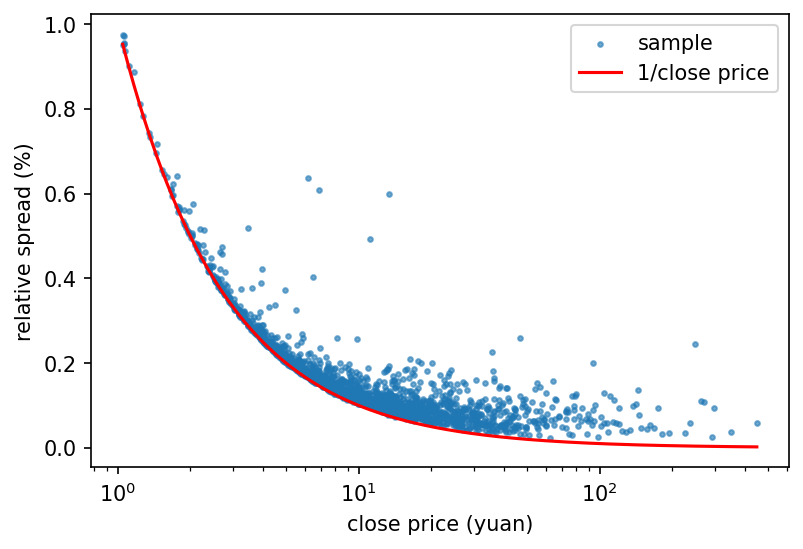

In [10]:
plt.figure(dpi=150)
plt.scatter(se.data.data_dic['close'][242, univ[242]], 
            se.data.spread_dic['relative_spread'][242, univ[242]]*100, alpha=0.6, s=5, label='sample')
x = np.sort(se.data.data_dic['close'][242, univ[242]])
plt.plot(x, 1/x, alpha=1, color='r',label='1/close price')
plt.legend()
plt.xlabel('close price (yuan)')
plt.ylabel('relative spread (%)')
plt.xscale('log')
plt.show()

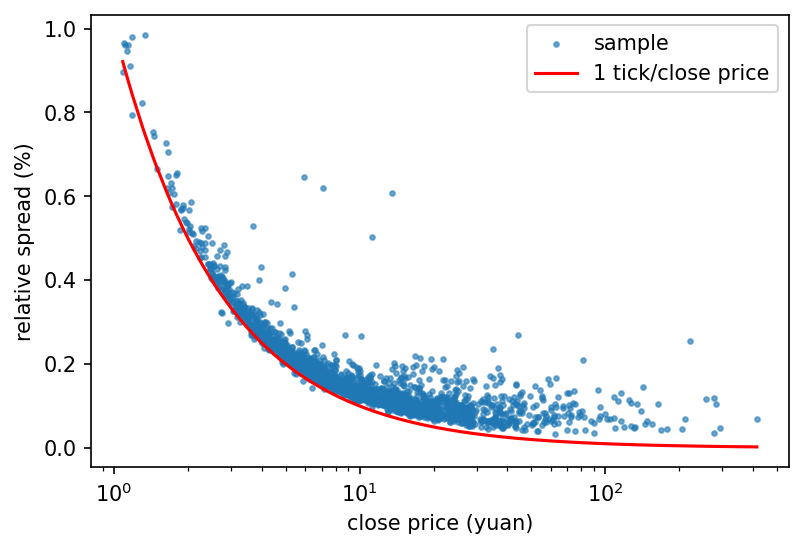

In [19]:
import pickle
with open(r"C:\华为云盘\学习资料\博士\博一下\ML for liquidity\code\SZSE\data\signal_spread.pkl", 'rb') as f:
    spread = pickle.load(f)
with open(r"C:\华为云盘\学习资料\博士\博一下\ML for liquidity\code\SZSE\data\target_rela.pkl", 'rb') as f:
    rela = pickle.load(f)
 
plt.figure(figsize=(6,3.92), dpi=150)
plt.scatter(spread[:, :, 7][242], 
            rela[242]*100+0.01, alpha=0.6, s=5, label='sample')
x = np.sort(spread[:, :, 7][242])
plt.plot(x, 1/x, alpha=1, color='r',label='1 tick/close price')
plt.legend()
plt.xlabel('close price (yuan)')
plt.ylabel('relative spread (%)')
plt.xscale('log')
plt.show()

In [10]:
spread[:, 242, 7]

array([    nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,  8.184 ,  8.6935,
        9.272 ,  9.765 , 10.2115, 10.661 , 11.055 , 11.444 , 11.827 ,
       12.2915, 12.6715, 12.995 , 13.276 , 13.505 , 13.619 , 13.6615,
       13.591 , 13.6025, 13.615 , 13.544 , 13.437 , 13.4085, 13.2405,
       13.135 , 13.0355, 12.87  , 12.7195, 12.5065, 12.3175, 12.034 ,
       11.81  , 11.6005, 11.346 , 11.106 , 10.9515, 10.8195, 10.7225,
       10.595 , 10.3995, 10.2315, 10.0575,  9.818 ,  9.6785,  9.5425,
        9.435 ,  9.342 ,  9.253 ,  9.243 ,  9.173 ,  9.116 ,  9.0515,
        8.9955,  8.9825,  8.9655,  8.919 ,  8.856 ,  8.8135,  8.781 ,
        8.744 ,  8.718 ,  8.68  ,  8.643 ,  8.582 ,  8.5295,  8.509 ,
        8.5   ,  8.492 ,  8.453 ,  8.4125,  8.386 ,  8.362 ,  8.312 ,
        8.246 ,  8.172 ,  8.119 ,  8.0695,  8.03  ,  7.985 ,  7.9715,
        7.943 ,  7.9

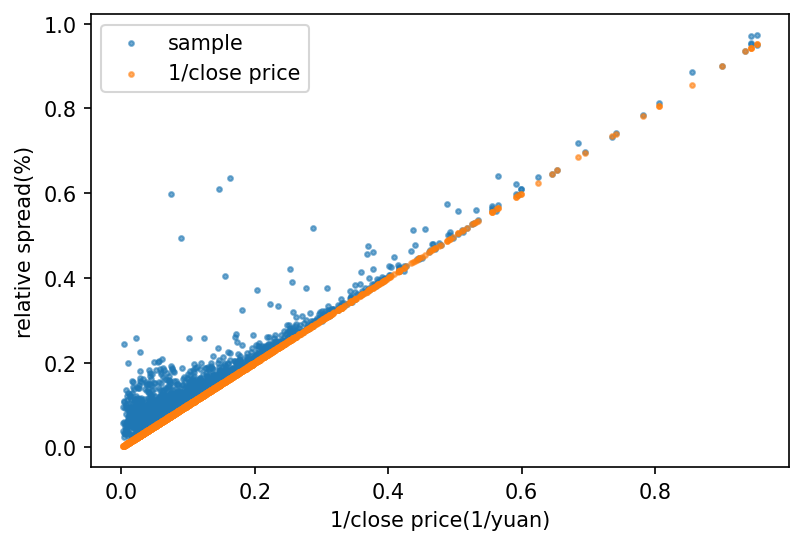

In [61]:
plt.figure(dpi=150)

plt.scatter(1/se.data.data_dic['close'][242, univ[242]], 
            se.data.spread_dic['relative_spread'][242, univ[242]]*100, alpha=0.6, s=5, label='sample')
plt.scatter(1/se.data.data_dic['close'][242, univ[242]], 
            1/se.data.data_dic['close'][242, univ[242]], alpha=0.6, s=5, label='1/close price')
plt.legend()
plt.legend()
plt.xlabel('1/close price(1/yuan)')
plt.ylabel('relative spread(%)')
plt.show()